In [20]:
import numpy as np 
import matplotlib.pyplot as plt
import pywt
import re
import cv2

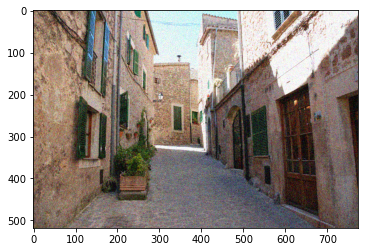

In [22]:
img = plt.imread('FFDNET_IPOL/noisy.png')
plt.imshow(img)
plt.show()

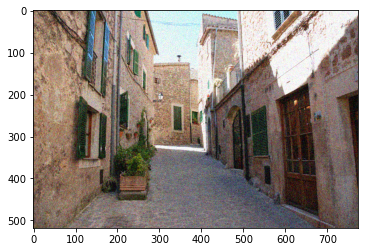

In [24]:
norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)
plt.imshow(norm_image)
plt.show()

In [25]:

N1, N2 = 10, 32

def dividing_into_patches(img):
    """Divides an input image into patches of size N1xN1"""
    n, p = img.shape[0], img.shape[1]
    patches = []
    n_10, p_10 = n//10, p//10
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                patches.append(img[i*N1:i*N1+10, j*N1:j*N1+10, :])
            elif i == n_10 and j < p_10:
                patches.append(img[n-10:n, j*N1:j*N1+10, :])
            elif i < n_10 and j == p_10:
                patches.append(img[i*N1:i*N1+10, p-10:p, :])
            elif i == n_10 and j == p_10:
                patches.append(img[n-10:n, p-10:p, :])
    return np.array(patches) 

def similarity_matrix(patches):
    """Computes the similarity matrix between the patches
    Returns a matrix of size N1xN1"""
    size = patches.shape[0]
    similarity = np.zeros((size,size))
    sim = 0

    # similarity computed with the Frobenius norm
    # leave the 0 similarity with itself to make sure every patch will be in S
    for i in range(size):
        for j in range(size):
            sim = np.linalg.norm(patches[i] - patches[j])
            similarity[i][j] = sim
    return similarity    

def building_the_look_up_table(similarity):
    """Builds a dictionnary by taking for each patch, the
    N2 most similar patches (including itself to make sure
    that all patches are in S"""
    S = {}
    n = similarity.shape[0]
    for i in range(n):
        idx = np.argpartition(similarity[i], N2)
        S['patch ' + str(i)] = idx[:N2]
    return S

def block_matching(img):

    # Dividing image into patches
    patches = dividing_into_patches(img)

    # Computing similarity matrix
    similarity = similarity_matrix(patches)

    # Building look-up-table
    look_up_table = building_the_look_up_table(similarity)

    return patches, look_up_table

In [27]:
patches, look_up_table = block_matching(norm_image)

In [28]:
def Gamma(q, tau):
    """Shrinkage Operator"""
    return q**3/(q**2+tau**2)

In [29]:
def building_gkj_array(patch_ind, look_up_table, patches, N1, N2):
    """For each S_j, we build a group gkj_tilde which is the 3D
    array of size N1xN1xN2 formed by stacking the blocks extracted
    from y_tilde_k"""
    gkj_tilde = np.zeros((N1,N1,N2,3))
    idx = look_up_table['patch ' + str(patch_ind)]
    for i in range(len(idx)):
        gkj_tilde[:,:,i] = patches[idx[i]]
    return gkj_tilde

In [30]:
gkj_tilde = building_gkj_array(1, look_up_table, patches, N1, N2)
print(gkj_tilde[0,0,:,0])

[181.  93.  84.  93.  53.  45.  47.  17.  80.  91.  88.  37.  65.  46.
  39.  98.  64.  61.  83.  83.  77.  63.  24.  86.  45.  60.  55.  18.
  73.  77.  45. 134.]


In [62]:
def transform_haar_wavelet(gkj_tilde, tau):
    """Computes gkj_hat by applying the wavelet transform,
    the shrinkage operator and the inverse wavelet transform"""
    gkj_hat = np.zeros_like(gkj_tilde)
    coeffs = pywt.wavedec2(gkj_tilde, 'haar', axes=(0, 1), level=2)
    coeffs_rec = [coeffs[0]]
    for i in range(1, len(coeffs)):
        coeffs_rec.append((Gamma(coeffs[i][0],tau),Gamma(coeffs[i][0],tau),Gamma(coeffs[i][0],tau)))
    gkj_hat = pywt.waverec2(coeffs_rec, 'haar', axes=(0, 1))
    return gkj_hat

In [63]:
tau = 7.5
gkj_hat = transform_haar_wavelet(gkj_tilde, tau)
print(gkj_hat[0,0,:,0])

[209.11735402 115.25308104 148.10692989  77.89877954  25.08994234
  85.93393184  37.74186038  37.37566297  79.78438114  64.87201143
 123.62557857  20.00354565  81.68701378  61.05976313 117.81245656
 105.74001273  49.9625      68.10492152  95.82597054 135.59739504
  90.22516329 119.43994901  23.49834071  65.50146523  45.62623815
  59.69292307  22.92859769 -39.42970763  42.54496606 100.06204931
  86.07232409 161.49637777]


In [64]:
def transform_over_all_img(look_up_table,patches,tau, N1, N2):
    """Applies the haar wavelet to all the image patches"""
    n = patches.shape[0]
    transform = []
    for i in range(n):
        gkj_tilde = building_gkj_array(i, look_up_table, patches, N1, N2)
        gkj_hat = transform_haar_wavelet(gkj_tilde, tau)
        transform.append(gkj_hat)
    return np.array(transform)

In [81]:
# def weight_j(patch_ind, look_up_table, patches, tau, N1, N2):
#     """Computes the weight defined in the article for a given gkj_tilde"""
#     gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches, N1, N2)
#     n, p = gkj_tilde.shape[0], gkj_tilde.shape[1]
#     summing = 0
#     wkj = []
#     for i in range(n):
#         for j in range(p):
#             coeffs0 = pywt.wavedec(gkj_tilde[i,j,:,0], 'haar', level=2)
#             coeffs1 = pywt.wavedec(gkj_tilde[i,j,:,1], 'haar', level=2)
#             coeffs2 = pywt.wavedec(gkj_tilde[i,j,:,2], 'haar', level=2)
#             for i in range(len(coeffs0)):
#                 summing0 = np.linalg.norm(coeffs0[i])**2
#                 summing1 = np.linalg.norm(coeffs1[i])**2
#                 summing2 = np.linalg.norm(coeffs2[i])**2
#     wkj += [(summing0/(summing0+tau**2))**(-2)] + [(summing1/(summing1+tau**2))**(-2)] + [(summing2/(summing2+tau**2))**(-2)]
#     return wkj

def weight_j(patch_ind, look_up_table, patches, tau, N1, N2):
    """Computes the weight defined in the article for a given gkj_tilde"""
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches, N1, N2)
    n, p = gkj_tilde.shape[0], gkj_tilde.shape[1]
    summing = 0
    for i in range(n):
        for j in range(p):
            coeffs = pywt.wavedec(gkj_tilde[i,j,:], 'haar', level=2)
            for i in range(len(coeffs)):
                summing = np.linalg.norm(coeffs[i])**2
    wkj = summing/(summing+tau**2)
    return wkj**(-2)

In [82]:
wkj = weight_j(1, look_up_table, patches, tau, N1, N2)
print(wkj)

1.003151181316701


In [83]:
def all_weights(look_up_table, patches, tau, N1, N2):
    """Computes all weights"""
    n = patches.shape[0]
    w = []
    for i in range(n):
        w.append(weight_j(i, look_up_table, patches, tau, N1, N2))
    return w

In [84]:
all_wkj = all_weights(look_up_table, patches, tau, N1, N2)

In [85]:
print(all_wkj[1])

1.003151181316701


In [69]:
def inverse_look_up_table(patches, look_up_table):
    """Inverses the look-up table to have access for a given patch
    to all the patches this particular patch was similar to"""
    inv = {}
    n = patches.shape[0]
    for i in range(n):
        for patch in look_up_table:
            if i in look_up_table[patch]:
                num = int(re.findall(r'\d+', patch)[0])
                if ('patch '+str(i)) in inv.keys():
                    inv['patch '+str(i)] += [(num,np.where(look_up_table[patch] == i)[0][0])]
                else: 
                    inv['patch '+str(i)] = [(num,np.where(look_up_table[patch] == i)[0][0])]
    return inv

In [42]:
inv = inverse_look_up_table(patches, look_up_table)

In [86]:
all_transforms = transform_over_all_img(look_up_table,patches,tau, N1, N2)

In [19]:
def multiply(w, matrix):
    mul = np.zeros_like(matrix)
    n, p = matrix.shape[0], matrix.shape[1]
    for i in range(n):
        for j in range(p):
            mul[i,j] = np.array([w[0]*matrix[i,j,0], w[1]*matrix[i,j,1], w[2]*matrix[i,j,2]])
    return mul

In [20]:
w = [217593.42287019352, 42300.108146808016, 48302.790926319605]
mat = patches[0]
print(mat[0,0])
print(multiply(w, mat)[0,0])

[0.44705883 0.5803922  0.09019608]
[97277.06   24550.652   4356.7227]


In [21]:
X = np.array([[[1,1,1], [1,1,1], [1,1,1]], [[1,1,1], [1,1,1], [1,1,1]], [[1,1,1], [1,1,1], [1,1,5]]])
print(X.shape)
w = [1,2,3]
print(X/w)

(3, 3, 3)
[[[1.         0.5        0.33333333]
  [1.         0.5        0.33333333]
  [1.         0.5        0.33333333]]

 [[1.         0.5        0.33333333]
  [1.         0.5        0.33333333]
  [1.         0.5        0.33333333]]

 [[1.         0.5        0.33333333]
  [1.         0.5        0.33333333]
  [1.         0.5        1.66666667]]]


In [91]:
# def new_patches(look_up_table, inv, patches, tau, N1, N2, all_transforms, weights):
#     """Computes the new patches using the found weights and gkj_hats"""
#     new_patches = []
#     for patch in inv:
#         summing = np.zeros((N1,N1,3))
#         normalization = np.zeros((N1,3))
#         for pat in inv[patch]:
#             (ind_patch, position) = pat
#             new_patch = all_transforms[ind_patch,:,:,position]
#             # summing += multiply(weights[ind_patch],new_patch)
#             summing += weights[ind_patch]*new_patch
#             normalization += np.array([weights[ind_patch][0], weights[ind_patch][1], weights[ind_patch][2]])
#         new_patches.append(summing / normalization)
#     return np.array(new_patches)

def new_patches(look_up_table, inv, patches, tau, N1, N2, all_transforms, weights):
    """Computes the new patches using the found weights and gkj_hats"""
    new_patches = []
    for patch in inv:
        summing = np.zeros((N1,N1, 3))
        normalization = 0
        for pat in inv[patch]:
            (ind_patch, position) = pat
            new_patch = all_transforms[ind_patch,:,:,position]
            summing += weights[ind_patch]*new_patch
            normalization += weights[ind_patch]
        new_patches.append(summing / normalization)
    return np.array(new_patches)

In [92]:
new_patch = new_patches(look_up_table, inv, patches, tau, N1, N2, all_transforms, all_wkj)

In [93]:
print(new_patch.shape)

(4056, 10, 10, 3)


In [94]:
def image_estimate(new_patches, img, N1):
    """Computes the denoised image thanks to the new computed patches"""
    n, p = img.shape[0], img.shape[1]
    new_image = np.zeros((n, p, 3))
    n_10, p_10 = n//10, p//10
    cpt = 0
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                new_image[i*N1:i*N1+N1, j*N1:j*N1+N1] = new_patches[cpt]
            elif i == n_10 and j < p_10:
                new_image[i*N1:n, j*N1:j*N1+N1] = new_patches[cpt][N1-(n-i*N1):,:]
            elif i < n_10 and j == p_10:
                new_image[i*N1:i*N1+N1, j*N1:p] = new_patches[cpt][:,N1-(p-j*N1):]
            elif i == n_10 and j == p_10:
                new_image[i*N1:n, j*N1:p] = new_patches[cpt][N1-(n-i*N1):,N1-(p-j*N1):]
            cpt += 1
    return np.clip(new_image, 0, 255).astype(np.uint8)

In [95]:
new_img = image_estimate(new_patch, norm_image, N1)

In [96]:
print(new_img[0,0])
print(norm_image[0,0])
img_clean = plt.imread('FFDNET_IPOL/input.png')
img_clean = cv2.normalize(img_clean, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img_clean = img_clean.astype(np.uint8)
print(img_clean[0,0])

[157 201  21]
[114 148  23]
[122  94  76]


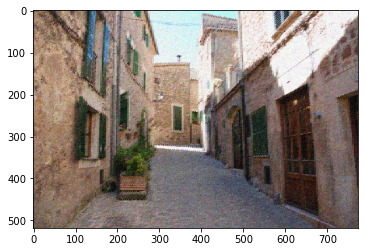

In [97]:
plt.imshow(new_img)
plt.show()

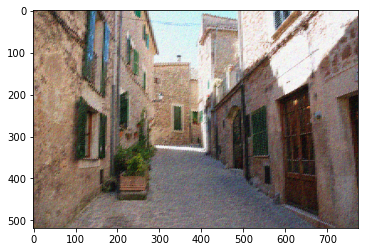

In [98]:
coeffs = pywt.wavedec2(norm_image, 'haar', axes=(0, 1), level=2)
coeffs_rec = [coeffs[0]]
for i in range(1, len(coeffs)):
    coeffs_rec.append((Gamma(coeffs[i][0],tau),Gamma(coeffs[i][0],tau),Gamma(coeffs[i][0],tau)))
new_image = np.clip(pywt.waverec2(coeffs_rec, 'haar', axes=(0, 1)), 0, 255).astype(np.uint8)

plt.imshow(new_image)
plt.show()

In [79]:
print(new_image[0:5,0:5])

[[[157 201  21]
  [137 108  87]
  [180 136  69]
  [ 99  89  84]
  [186 169 136]]

 [[137 108  87]
  [137 108  87]
  [ 99  89  84]
  [ 99  89  84]
  [127 162 128]]

 [[ 32  98  49]
  [148 102  91]
  [113  76  87]
  [121 110  78]
  [ 67  70  40]]

 [[148 102  91]
  [148 102  91]
  [121 110  78]
  [121 110  78]
  [163  82  95]]

 [[171 141  24]
  [ 78  99  67]
  [207  98  45]
  [102  81  95]
  [146  86  81]]]


In [80]:
print(img_clean[0:5,0:5])

[[[122  94  76]
  [138 105  82]
  [148 115  91]
  [129 102  82]
  [135 109  94]]

 [[ 84  62  50]
  [124  94  73]
  [148 114  88]
  [132 104  80]
  [123  98  79]]

 [[ 73  51  41]
  [109  81  69]
  [140 106  84]
  [149 119  93]
  [105  84  67]]

 [[115  89  74]
  [108  84  69]
  [124  95  78]
  [152 113  87]
  [158 116  85]]

 [[120  96  80]
  [108  88  73]
  [123  99  83]
  [152 112  89]
  [175 136 105]]]


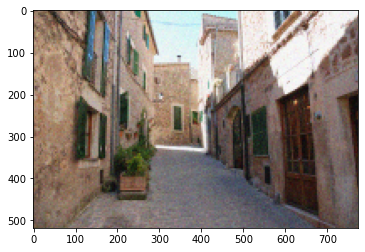

In [37]:
plt.imshow(image)
plt.show()

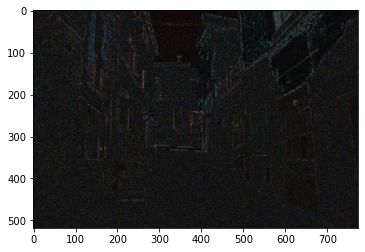

In [41]:
plt.imshow(abs(new_img-img))
plt.show()

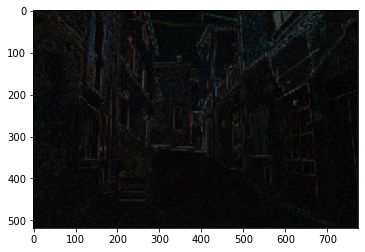

In [43]:
plt.imshow(abs(new_img-img_clean))
plt.show()

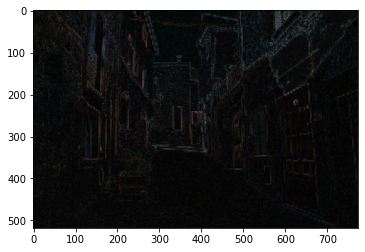

In [44]:
plt.imshow(abs(image-img_clean))
plt.show()